In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, Concatenate, BatchNormalization, GlobalAveragePooling1D # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv(r'../Dataset/NCA Preprocessed/master_features_nca.csv')
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [5]:
# -------------------------
# 1. One-hot encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 2. Drop useless columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 3. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Target
Y = df_dropped['SOH'].values

# Features before splitting
X_ic_all = df_dropped[ic_cols].values                # shape: (N, 20)
X_cycle_all = df_dropped[[cycle_col]].values         # shape: (N, 1)
X_onehot_all = df_dropped[one_hot_cols].values       # shape: (N, 6)

# -------------------------
# 4. Train/test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_cat_train, X_cat_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 5. Scale IC features
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 6. Scale cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 7. Build final CONTEXT vector (cycle + one-hot)
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_cat_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_cat_test], axis=1)

# -------------------------
# 8. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# -------------------------
# 9. Reshape IC features for CNN+LSTM (20 timesteps, 1 feature)
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)   # shape: (N, 20, 1)
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

print("IC input:", X_ic_train.shape)
print("Context input:", X_context_train.shape)
print("Target:", y_train.shape)


IC input: (18115, 20, 1)
Context input: (18115, 7)
Target: (18115,)


In [4]:
# IC input
ic_input = Input(shape=(X_ic_train.shape[1], X_ic_train.shape[2]), name='ic_input')

x = Conv1D(64, 3, padding='same', activation='relu')(ic_input)
x = BatchNormalization()(x)

x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv1D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv1D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling1D()(x)

# Context branch
context_input = Input(shape=(X_context_train.shape[1],), name='context_input')

c = Dense(32, activation='relu')(context_input)
c = BatchNormalization()(c)

# Combine IC + Context
combined = Concatenate()([x, c])

z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)

z = Dense(32, activation='relu')(z)
z = Dropout(0.2)(z)

output = Dense(1, activation='linear')(z)

# Build model
model_cnn = Model(inputs=[ic_input, context_input], outputs=output)

# Compile
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

model_cnn.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ic_input            │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 20, 64)    │        256 │ ic_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 64)    │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 20, 128)   │     24,704 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 20, 128)   │     49,280 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 128)   │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        256 │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,929 (394.25 KB)

 Trainable params: 100,097 (391.00 KB)

 Non-trainable params: 832 (3.25 KB)

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn.keras', monitor='val_loss',
                              save_best_only=True, verbose=1)

history = model_cnn.fit(
    [X_ic_train, X_context_train], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/100
451/453 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3794 - mae: 0.4368
Epoch 1: val_loss improved from None to 0.25911, saving model to best_cnn.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.2351 - mae: 0.3511 - val_loss: 0.2591 - val_mae: 0.4381
Epoch 2/100
450/453 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1401 - mae: 0.2751
Epoch 2: val_loss improved from 0.25911 to 0.06690, saving model to best_cnn.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1243 - mae: 0.2593 - val_loss: 0.0669 - val_mae: 0.2119
Epoch 3/100
453/453 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1071 - mae: 0.2393
Epoch 3: val_loss improved from 0.06690 to 0.06637, saving model to best_cnn.keras
453/453 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1047 - mae: 0.2356 - val_loss: 0.0664 - val_mae: 0.2041
Epoch 4/100
449/453 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0931 - mae: 0.2228
Epoch 4: val_loss did not improve from 0.06637
453/453 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - mae: 0.0944
Test MAE (normalized): 0.0944
Test MSE (normalized): 0.0150
Test MAE (original SOH units): 0.6287


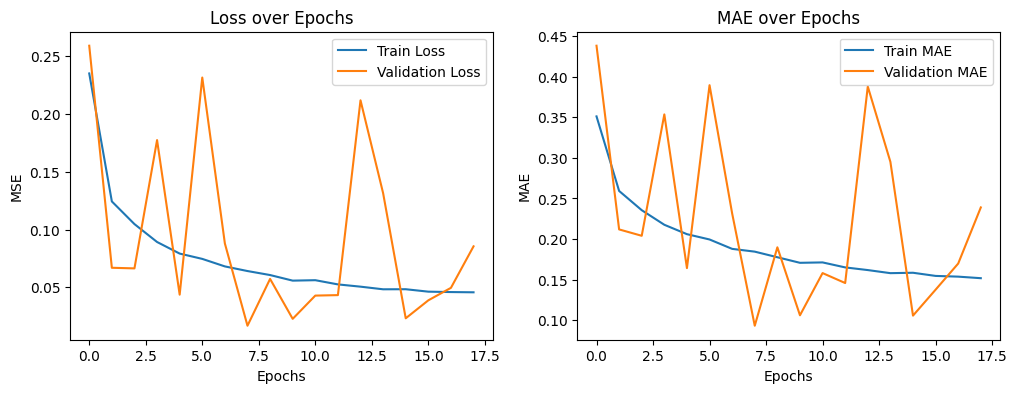

In [6]:
test_loss, test_mae = model_cnn.evaluate([X_ic_test, X_context_test], y_test, verbose=1)
print(f"Test MAE (normalized): {test_mae:.4f}")
print(f"Test MSE (normalized): {test_loss:.4f}")

# Inverse transform MAE to original units
test_mae_real = test_mae * y_std
print(f"Test MAE (original SOH units): {test_mae_real:.4f}")

# ======================================
# 6. Plot training history
# ======================================
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE over Epochs')

plt.show()

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


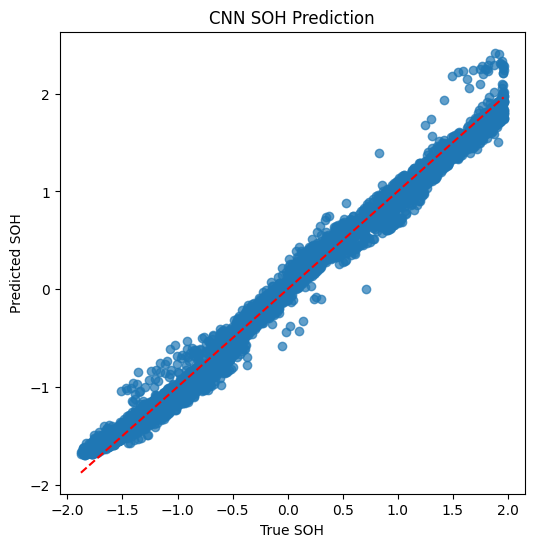

In [7]:
import matplotlib.pyplot as plt

y_pred = model_cnn.predict([X_ic_test, X_context_test]).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True SOH")
plt.ylabel("Predicted SOH")
plt.title("CNN SOH Prediction")
plt.show()

In [8]:
r2 = r2_score(y_test, y_pred)

print(f"R-squared (normalized): {r2:.4f}")

y_test_real = y_test * y_std + y_mean
y_pred_real = y_pred * y_std + y_mean

r2_real = r2_score(y_test_real, y_pred_real)
print(f"R-squared (original SOH units): {r2_real:.4f}")

R-squared (normalized): 0.9848
R-squared (original SOH units): 0.9848


In [6]:
X_ic_test_25 = []
X_context_test_25 = []
X_ic_test_35 = []
X_context_test_35 = []
X_ic_test_45 = []
X_context_test_45 = []
y_test_25 = []
y_test_35 = []  
y_test_45 = []

for i in range(X_context_test.shape[0]):
    if X_context_test[i, 1] > 0:      # temp_25 one-hot
        X_ic_test_25.append(X_ic_test[i])
        X_context_test_25.append(X_context_test[i])
        y_test_25.append(y_test[i])
    if X_context_test[i, 2] > 0:      # temp_35 one-hot
        X_ic_test_35.append(X_ic_test[i])
        X_context_test_35.append(X_context_test[i])
        y_test_35.append(y_test[i])
    if X_context_test[i, 3] > 0:      # temp_45 one-hot
        X_ic_test_45.append(X_ic_test[i])
        X_context_test_45.append(X_context_test[i])
        y_test_45.append(y_test[i])

X_ic_test_25 = np.array(X_ic_test_25)
X_ic_test_35 = np.array(X_ic_test_35)
X_ic_test_45 = np.array(X_ic_test_45)

X_context_test_25 = np.array(X_context_test_25)
X_context_test_35 = np.array(X_context_test_35)
X_context_test_45 = np.array(X_context_test_45)

y_test_25 = np.array(y_test_25)
y_test_35 = np.array(y_test_35)
y_test_45 = np.array(y_test_45)

print(X_ic_test_25.shape)
print(X_ic_test_35.shape)
print(X_ic_test_45.shape)

print(X_context_test_25.shape)
print(X_context_test_35.shape)
print(X_context_test_45.shape)


print(y_test_25.shape)
print(y_test_35.shape)
print(y_test_45.shape)

(1163, 20, 1)
(241, 20, 1)
(3125, 20, 1)
(1163, 7)
(241, 7)
(3125, 7)
(1163,)
(241,)
(3125,)


In [7]:
X_ic_test_25_seq = np.expand_dims(X_ic_test_25, axis=2)
X_ic_test_35_seq = np.expand_dims(X_ic_test_35, axis=2)
X_ic_test_45_seq = np.expand_dims(X_ic_test_45, axis=2)
print(X_ic_test_25_seq.shape)
print(X_ic_test_35_seq.shape)
print(X_ic_test_45_seq.shape)

(1163, 20, 1, 1)
(241, 20, 1, 1)
(3125, 20, 1, 1)


In [8]:
cnn = keras.models.load_model(r'best_cnn.keras')

In [9]:
y_pred_25_scaled = cnn.predict([X_ic_test_25_seq, X_context_test_25]).flatten()
y_pred_35_scaled = cnn.predict([X_ic_test_35_seq, X_context_test_35]).flatten()
y_pred_45_scaled = cnn.predict([X_ic_test_45_seq, X_context_test_45]).flatten()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [10]:
y_pred_25 = y_pred_25_scaled * y_std + y_mean
y_pred_35 = y_pred_35_scaled * y_std + y_mean
y_pred_45 = y_pred_45_scaled * y_std + y_mean

y_true_25 = y_test_25 * y_std + y_mean
y_true_35 = y_test_35 * y_std + y_mean
y_true_45 = y_test_45 * y_std + y_mean


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics(y_t, y_p):
    return (mean_absolute_error(y_t, y_p),
            mean_squared_error(y_t, y_p),
            r2_score(y_t, y_p))

mae_25, mse_25, r2_25 = metrics(y_true_25, y_pred_25)
print("25C → MAE:", mae_25, "MSE:", mse_25, "R²:", r2_25)


mae_35, mse_35, r2_35 = metrics(y_true_35, y_pred_35)
print("35C → MAE:", mae_35, "MSE:", mse_35, "R²:", r2_35)

mae_45, mse_45, r2_45 = metrics(y_true_45, y_pred_45)
print("45C → MAE:", mae_45, "MSE:", mse_45, "R²:", r2_45)


25C → MAE: 0.7764998569030727 MSE: 1.0804076086255938 R²: 0.9692443491036842
35C → MAE: 0.677580045007016 MSE: 0.8134405364966145 R²: 0.9727219135803179
45C → MAE: 0.5699075402539301 MSE: 0.4991066743988162 R²: 0.9870303355213329


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(y_true, y_pred, title):
    plt.scatter(y_true, y_pred, alpha=0.6, s=15)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel("True SOH", fontsize=12)
    plt.ylabel("Predicted SOH", fontsize=12)
    plt.grid(True)


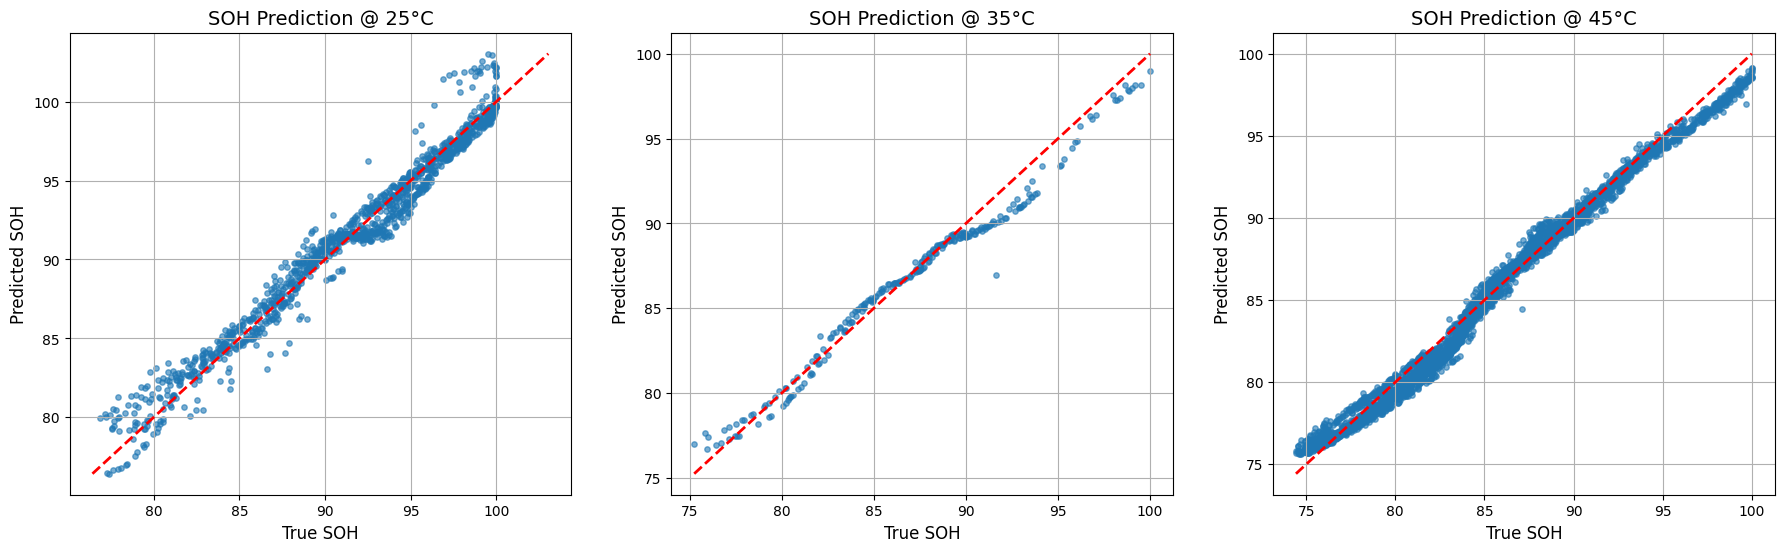

In [13]:
plt.figure(figsize=(22,6))

plt.subplot(1,3,1)
plot_scatter(y_true_25, y_pred_25, "SOH Prediction @ 25°C")

plt.subplot(1,3,2)
plot_scatter(y_true_35, y_pred_35, "SOH Prediction @ 35°C")

plt.subplot(1,3,3)
plot_scatter(y_true_45, y_pred_45, "SOH Prediction @ 45°C")

plt.show()
